$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + e_i$  

$b = (X^TX)^{−1} X^TY$

# Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from linear_regression import LinearRegression as lr

data = pd.read_csv("../data/Small-diameter-flow.csv", index_col=0)

# Exploratory data analysis

<Axes: >

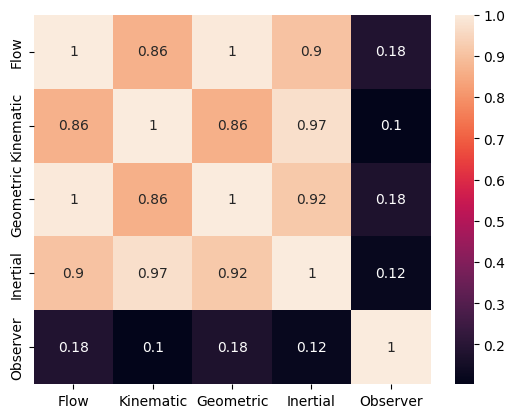

In [2]:
sns.heatmap(data.corr(), annot=True)

In [3]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# sns.scatterplot(data=data, x="Flow", y="Geometric", ax=axes[0])
# axes[0].set_title('Flow vs Geometric')

# sns.scatterplot(data=data, x="Flow", y="Inertial", ax=axes[1])
# axes[1].set_title('Flow vs Inertial')

# sns.scatterplot(data=data, x="Flow", y="Kinematic", ax=axes[2])
# axes[2].set_title('Flow vs Kinematic')

# plt.tight_layout()
# plt.show()

# Creating sets

In [4]:
# print(f"Length of ...\nX: {len(X)}")

data_shuffled = data.sample(frac=1, random_state=42)  # setting the seed for reproducibility

train_indices = round(0.8 * len(data_shuffled))
val_indices = round(0.25 * train_indices)
test_indices = round(0.2 * len(data_shuffled))

# print(f"Train:{train_indices}\nVal: {val_indices}\nTest: {test_indices}\n")

test_df = pd.DataFrame(data_shuffled[:test_indices])
train_df = pd.DataFrame(data_shuffled[test_indices:])

# print(f"Length of ...\nTrain: {len(train_df)}\nTest: {len(test_df)}\n")

val_df = pd.DataFrame(train_df[:val_indices])
train_df = pd.DataFrame(train_df[val_indices:])

# print(f"Length of ...\nTrain: {len(train_df)}\nVal: {len(val_df)}\n")

In [5]:
X_train = np.column_stack([np.ones(len(train_df)), train_df["Kinematic"], train_df["Geometric"], train_df["Inertial"], train_df["Observer"]])
y_train = train_df["Flow"]

X_val = np.column_stack([np.ones(len(val_df)), val_df["Kinematic"], val_df["Geometric"], val_df["Inertial"], val_df["Observer"]])
y_val = val_df["Flow"]

X_test = np.column_stack([np.ones(len(test_df)), test_df["Kinematic"], test_df["Geometric"], test_df["Inertial"], test_df["Observer"]])
y_test = test_df["Flow"]

In [6]:
display(train_df.head(1))
print(X_train[:1])
print()

,Flow,Kinematic,Geometric,Inertial,Observer
22,-11.491985,0.494696,-5.20665,-12.453012,0.0


[[  1.           0.49469624  -5.20665018 -12.45301184   0.        ]]



# Running the model

In [7]:
model = lr()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
evaluation = model.evaluate(X_test, y_test)
for key, value in evaluation.items():
    if isinstance(value, np.float64):
        print(f"{key}: {value.item()}")
    else:
        print(f"{key}: {value}")

Coefficients: [-1.43774999 -1.43774999  0.89760272  3.58090965 -0.76326946  0.02806431]
Variance: 0.00836071996361811
Standard deviation: 0.09143697262933692
SSE: 0.28426447876301575
SST: 87.81306948077552
SSR: 87.5288050020125
R_squared: 0.9967628454346963
r: 0.9988135739245642
MSE: 0.007106611969075394
RMSE: 0.08430072341964448
RSE: 0.08649071729367319
F_stat: 2093.8102312455476
F_pvalue: 2.7475141921051683e-41
ti_pvalues: [np.float64(4.904274326608841e-24), np.float64(4.904274323364126e-24), np.float64(2.4811437675466465e-38), np.float64(1.9768904516208276e-64), np.float64(1.2150603523737259e-39)]
r0: PearsonRResult(statistic=np.float64(0.8928321121153127), pvalue=np.float64(9.818781282209e-15))


Det vore bra (men inte nödvändigt) att standardisera datan (att medlet hamnar på noll). 

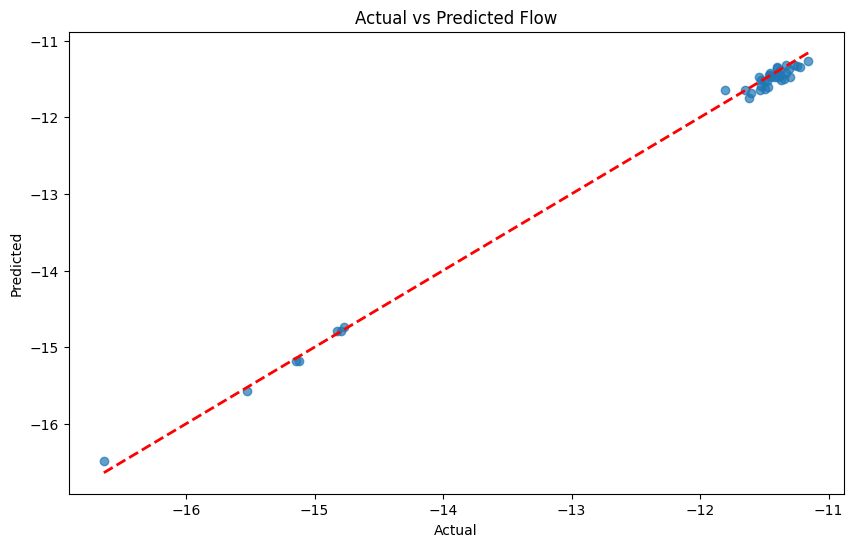

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Flow')
plt.show()

In [17]:
X = np.column_stack((np.ones(len(X_train)), X_train))
b = np.linalg.pinv(X.T @ X) @ X.T @ y_train

r = stats.pearsonr(X[:,2], X[:,3])
print(r)
print(r[0])
print(r[1])

PearsonRResult(statistic=np.float64(0.8687726312738631), pvalue=np.float64(3.3448178951169536e-37))
0.8687726312738631
3.3448178951169536e-37


In [50]:
X_r = X[:,2:5]      # i .py sen måste det vara 1:4
print(X_r.shape[1])
temp = []
for i in range(X_r.shape[1]):
    if i == 3:
        r = stats.pearsonr(X[:,i], X[:,i+1])
    r = stats.pearsonr(X[:,i], X[:,i+1])
    temp.append(r)

3
